## Summary

Issues with the sample code are as follows. 

**Visual Representation:** Consider using visuals (graphs, charts) instead of direct number comparison. Humans perceive scale better in graphs, enhancing the understanding of the data.

**Feature Engineering:** Implement more feature engineering techniques. The current code lacks extensive feature usage and encodings, which can significantly impact model performance.

**Metrics for Imbalanced Dataset:** Ensure appropriate metrics are used for datasets with class imbalance issues. The current metrics may not accurately reflect model performance in such scenarios.

**Code Documentation:** The code lacks comprehensive documentation. Include comments and explanations to enhance readability and maintainability.


Overall, these are the different initial steps we can take for a successful project completetion ensuring delivery. 

- Version Contorl
    - Initialize Git for version control.
    - Create a repository for tracking changes.
- Set up a testing framework.
- Unit Testing
    - Develop and execute unit tests for components.
- Integration Testing
    - Test model integration with the system.
- Continuous Integration (CI)
    - Implement CI pipelines for automated testing.
    - Trigger CI on code pushes.
- Continuous Delivery (CD)
    - Implement CD pipeline for automated, reliable deployment.
- Deployment Strategies
    - Consider Canary or Blue-Green deployment strategies.

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from constants import delete_col_list, categorical_cols, numeric_cols, model_cat_cols
from helper_functions import get_typecasted_cols, remove_highly_correlated_features, getLogisticRegressionResults, getDecisionTreeResults, getRandomForestResults, get_log_features
from sklearn.model_selection import train_test_split
from helper_classes import MissingValueImputer
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.tree import plot_tree
import warnings
import shap


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

%matplotlib inline

In [2]:
train_raw = pd.read_csv('../Data/inputs/train.csv')
test_raw = pd.read_csv('../Data/inputs/test.csv')
output_df = test_raw.copy(deep=True)
train_raw.head()


,index,borough,block,lot,schooldist,council,zipcode,firecomp,policeprct,healthcenterdistrict,healtharea,sanitboro,sanitdistrict,sanitsub,zonedist1,zonedist2,zonedist3,zonedist4,overlay1,overlay2,spdist1,spdist2,spdist3,ltdheight,splitzone,landuse,easements,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,otherarea,numbldgs,numfloors,unitstotal,lotfront,lotdepth,bldgfront,bldgdepth,ext,proxcode,irrlotcode,lottype,bsmtcode,assessland,assesstot,exemptland,exempttot,yearbuilt,yearalter1,yearalter2,histdist,landmark,builtfar,tract2010,xcoord,ycoord,zonemap,target__office
0,574546,BX,3717,64,8.0,18.0,10472.0,E096,43.0,26.0,3020.0,2.0,9.0,1A,R6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,1.0,0,2500,1540,0,1540,0,0,0,0,0,0,1,2.0,1,25.00,100.00,20.00,36.0,E,2.0,N,5.0,2.0,6532,19280,0,0,1940,0,0,NaN,NaN,0.62,48,1018914.0,239801.0,6C,False
1,12600,QN,15818,48,27.0,31.0,11691.0,E264,101.0,45.0,3800.0,4.0,14.0,2D,R4-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,1.0,0,1225,594,0,594,0,0,0,0,0,0,1,1.0,1,25.00,49.00,18.00,33.0,NaN,1.0,N,5.0,0.0,1621,4178,0,0,1930,0,0,NaN,NaN,0.48,99802,1051073.0,155952.0,31A,False
2,235922,BK,6787,7,22.0,48.0,11229.0,E276,61.0,35.0,7320.0,3.0,15.0,2D,R3-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,1.0,0,4200,2889,0,2889,0,0,0,0,0,0,2,2.0,2,42.00,100.00,27.00,57.0,NaN,1.0,N,5.0,2.0,20300,57028,1470,1470,1930,0,0,NaN,NaN,0.69,548,998378.0,161944.0,23B,False
3,202581,BK,672,30,15.0,38.0,11232.0,E228,72.0,39.0,4400.0,3.0,7.0,2D,M1-2D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,2.0,0,1669,2070,0,1380,0,0,0,0,0,0,1,2.0,3,16.67,100.17,16.67,41.0,NaN,3.0,N,5.0,1.0,2861,20242,0,0,1910,0,0,NaN,NaN,1.24,101,983777.0,178952.0,16B,False
4,155971,BK,6651,7501,21.0,44.0,11223.0,E330,62.0,37.0,8522.0,6.0,11.0,NaN,R7A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,4.0,1,4000,14369,2844,11525,2844,0,0,0,0,0,1,7.0,14,0.09,100.00,40.00,70.0,NaN,1.0,N,5.0,5.0,90001,1368456,0,356862,2002,0,0,NaN,NaN,3.59,426,990141.0,159965.0,22D,False


In [3]:
missing_values = train_raw.isna().sum().to_frame(name='missing_count')
missing_values['missing_percentage'] = (missing_values['missing_count'] / len(train_raw)) * 100

missing_values[missing_values['missing_percentage'] > 0].T

,schooldist,council,zipcode,firecomp,policeprct,healthcenterdistrict,healtharea,sanitboro,sanitdistrict,sanitsub,zonedist1,zonedist2,zonedist3,zonedist4,overlay1,overlay2,spdist1,spdist2,spdist3,ltdheight,splitzone,landuse,ext,proxcode,irrlotcode,lottype,bsmtcode,histdist,landmark,xcoord,ycoord,zonemap
missing_count,2203.000000,2417.000000,3327.00000,2804.000000,2372.000000,2126.000000,2649.000000,5093.000000,5065.000000,12701.00000,806.000000,671481.000000,687220.000000,687358.0000,627550.000000,687244.000000,605850.000000,687315.000000,687369.0,684950.000000,806.000000,2293.000000,407313.000000,397.000000,397.000000,397.000000,397.000000,663503.00000,686109.000000,19211.00000,19211.00000,787.000000
missing_percentage,0.320497,0.351631,0.48402,0.407932,0.345084,0.309295,0.385383,0.740941,0.736868,1.84777,0.117259,97.688578,99.978323,99.9984,91.297396,99.981815,88.140431,99.992144,100.0,99.648078,0.117259,0.333591,59.256818,0.057756,0.057756,0.057756,0.057756,96.52792,99.816692,2.79486,2.79486,0.114495


Deleting these features because a majority of them are null. 

index,zonedist2, zonedist3, zonedist2, zonedist3, zonedist4, overlay1, overlay2, spdist1, spdist2, spdist3, ltdheight, ext, histdist, landmark

In [4]:
train_raw.drop(delete_col_list, inplace = True, axis = 1)
test_raw.drop(delete_col_list, inplace = True, axis = 1)

train, test = get_typecasted_cols(train_raw, test_raw)

#Missing value imputation
imputer = MissingValueImputer()

# Fit the imputer on the training set
imputer.fit(train)

# Transform the training set
train_imputed = imputer.transform(train)

# Transform the test set using the same imputation values
test_imputed = imputer.transform(test)

Following are the imputation values : 
{
    'assessland': 114449.42596625684,
    'assesstot': 464146.7396973096,
    'bldgarea': 6392.346896645034,
    'bldgdepth': 46.086402703641056,
    'bldgfront': 25.656654795313717,
    'block': 2925,
    'borough': 'QN',
    'bsmtcode': 2.0,
    'builtfar': 1.0820545005667317,
    'comarea': 2138.0906427261048,
    'council': 51.0,
    'easements': 0.020991636224502414,
    'exemptland': 52668.13644054358,
    'exempttot': 170352.94208060007,
    'factryarea': 138.74561407337254,
    'firecomp': 'L170',
    'garagearea': 142.74771338247723,
    'healtharea': 800.0,
    'healthcenterdistrict': 51.0,
    'irrlotcode': 'N',
    'landuse': 1.0,
    'lot': 1,
    'lotarea': 8121.004752905645,
    'lotdepth': 103.82765476772445,
    'lotfront': 39.97719110115532,
    'lottype': 5.0,
    'numbldgs': 1.2805567315372093,
    'numfloors': 2.3212306344916773,
    'officearea': 767.0705996342576,
    'otherarea': 621.2406131204636,
    'policeprct': 105.0

<AxesSubplot:>

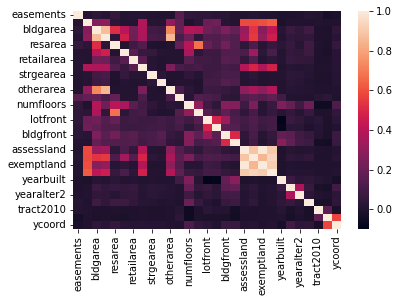

In [5]:
#correlation 
sns.heatmap(train_imputed.drop(categorical_cols+['target__office'], axis = 1).corr())

In [6]:
train_imputed, high_correlated_features = remove_highly_correlated_features(train_imputed)
test_imputed.drop(high_correlated_features, inplace = True, axis = 1)

categorical_cols = [feature for feature in categorical_cols if feature not in high_correlated_features] 
numeric_cols = [feature for feature in numeric_cols if feature not in high_correlated_features] 

Dropping following columns
['comarea', 'otherarea', 'assesstot', 'exemptland', 'exempttot']


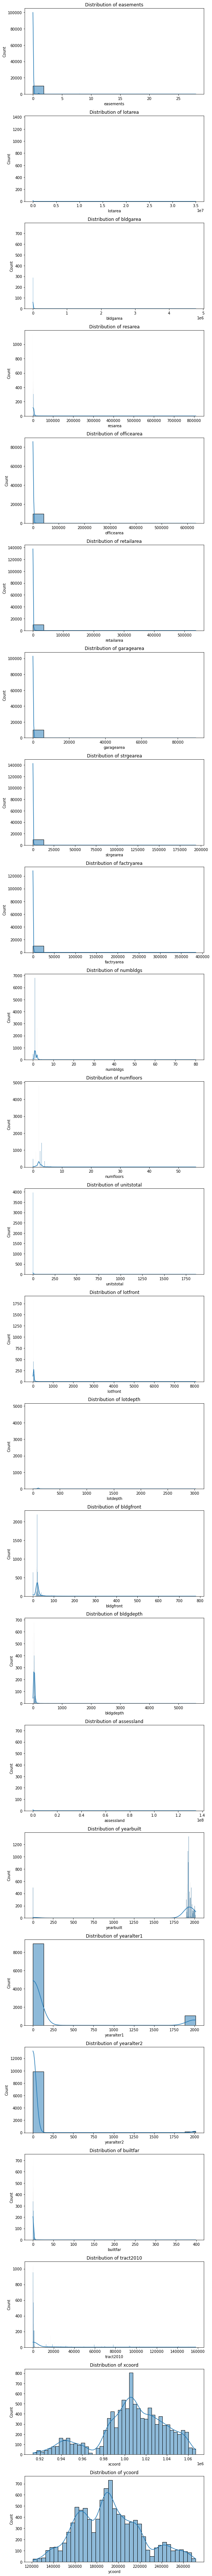

In [8]:
model_cols = numeric_cols + model_cat_cols
X = train_imputed[model_cols]
y = train_imputed['target__office']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

# Check distributions of all the numeric columns because we are going to use logistic regression. 
# Create subplots for each numeric column
fig, axes = plt.subplots(nrows=len(numeric_cols), figsize=(8, 4 * len(numeric_cols)))

# Loop through numeric columns and create distribution plots
for i, col in enumerate(numeric_cols):
    sns.histplot(X_train[col].sample(10000), kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# Adjust layout
plt.tight_layout()
plt.show()

#### All the numeric features are right skewed. Performing a log transformation for logistic regression

In [9]:
X_train_log = get_log_features(X_train, numeric_cols)
X_test_log = get_log_features(X_test, numeric_cols)
numeric_cols_logistic = [feature for feature in X_train_log if 'log_transformed' in feature]

data_dictionary = {
    'x_train' : X_train, 
    'y_train' : y_train, 
    'x_test' : X_test, 
    'y_test' : y_test
}

data_dictionary_logistic = {
    'x_train' : X_train_log, 
    'y_train' : y_train, 
    'x_test' : X_test_log, 
    'y_test' : y_test
}

best_estimator, feature_names, y_prob = getLogisticRegressionResults(data_dictionary_logistic, model_cat_cols, numeric_cols_logistic)

# Extract the coefficients (weights) from the Logistic Regression model
logistic_regression_model = best_estimator.named_steps['classifier']
coefficients = logistic_regression_model.coef_

# Create a dictionary to match coefficients with feature names
coefficients_dict = {feature: coef for feature, coef in zip(feature_names, coefficients[0])}

# Print the coefficients for each feature
print("\nCoefficients (Weights):")
for feature, coef in coefficients_dict.items():
    print(f"{feature}: {coef}")

Best Hyperparameters:
{'classifier__C': 0.01, 'classifier__penalty': 'l2'}
Test F1 score : 0.42950391644908614

Coefficients (Weights):
borough_BK: 0.05920130135676807
borough_BX: -0.16019297882066977
borough_MN: -0.06760255789437931
borough_QN: -0.3028980616016522
borough_SI: 0.4707165717351558
splitzone_N: -0.27246025348566255
splitzone_Y: 0.27168452826087164
irrlotcode_N: -0.14982149971623007
irrlotcode_Y: 0.1490457744914435
easements_log_transformed: -0.2712667392468414
lotarea_log_transformed: -0.16934004831481478
bldgarea_log_transformed: -0.03059255369972303
resarea_log_transformed: -0.8670886099703352
officearea_log_transformed: 1.1317394765687785
retailarea_log_transformed: -0.04677888533003681
garagearea_log_transformed: -0.03417753251080638
strgearea_log_transformed: -0.05218594920904421
factryarea_log_transformed: -0.19105938018470703
numbldgs_log_transformed: 0.10305440065341198
numfloors_log_transformed: -0.3956116014267237
unitstotal_log_transformed: 0.0576162751472454
l

Here are the interpretations for all the features:

1. **borough_BK: 0.0592**
   - Inference: The odds of the target event (e.g., property classification) increase by approximately 5.92% when the borough is Brooklyn compared to the reference category.

2. **borough_BX: -0.1602**
   - Inference: The odds of the target event decrease by approximately 16.02% when the borough is Bronx compared to the reference category.

3. **borough_MN: -0.0676**
   - Inference: The odds of the target event decrease by approximately 6.76% when the borough is Manhattan compared to the reference category.

4. **borough_QN: -0.3029**
   - Inference: The odds of the target event decrease by approximately 30.29% when the borough is Queens compared to the reference category.

5. **borough_SI: 0.4707**
   - Inference: The odds of the target event increase by approximately 47.07% when the borough is Staten Island compared to the reference category.

6. **splitzone_N: -0.2725**
   - Inference: The odds of the target event decrease by approximately 27.25% when the split zone is 'No' compared to the reference category.

7. **splitzone_Y: 0.2717**
   - Inference: The odds of the target event increase by approximately 27.17% when the split zone is 'Yes' compared to the reference category.

8. **irrlotcode_N: -0.1498**
   - Inference: The odds of the target event decrease by approximately 14.98% when the irregular lot code is 'No' compared to the reference category.

9. **irrlotcode_Y: 0.1490**
   - Inference: The odds of the target event increase by approximately 14.90% when the irregular lot code is 'Yes' compared to the reference category.

10. **easements_log_transformed: -0.2713**
    - Inference: A one-unit increase in the log-transformed easements is associated with a decrease of approximately 27.13% in the odds of the target event.

11. **lotarea_log_transformed: -0.1693**
    - Inference: A one-unit increase in the log-transformed lot area is associated with a decrease of approximately 16.93% in the odds of the target event.

12. **bldgarea_log_transformed: -0.0306**
    - Inference: A one-unit increase in the log-transformed building area is associated with a decrease of approximately 3.06% in the odds of the target event.

13. **resarea_log_transformed: -0.8671**
    - Inference: A one-unit increase in the log-transformed residential area is associated with a decrease of approximately 86.71% in the odds of the target event.

14. **officearea_log_transformed: 1.1317**
    - Inference: A one-unit increase in the log-transformed office area is associated with an increase of approximately 113.17% in the odds of the target event.

15. **retailarea_log_transformed: -0.0468**
    - Inference: A one-unit increase in the log-transformed retail area is associated with a decrease of approximately 4.68% in the odds of the target event.

16. **garagearea_log_transformed: -0.0342**
    - Inference: A one-unit increase in the log-transformed garage area is associated with a decrease of approximately 3.42% in the odds of the target event.

17. **strgearea_log_transformed: -0.0522**
    - Inference: A one-unit increase in the log-transformed storage area is associated with a decrease of approximately 5.22% in the odds of the target event.

18. **factryarea_log_transformed: -0.1911**
    - Inference: A one-unit increase in the log-transformed factory area is associated with a decrease of approximately 19.11% in the odds of the target event.

19. **numbldgs_log_transformed: 0.1031**
    - Inference: A one-unit increase in the log-transformed number of buildings is associated with an increase of approximately 10.31% in the odds of the target event.

20. **numfloors_log_transformed: -0.3956**
    - Inference: A one-unit increase in the log-transformed number of floors is associated with a decrease of approximately 39.56% in the odds of the target event.

21. **unitstotal_log_transformed: 0.0576**
    - Inference: A one-unit increase in the log-transformed total units is associated with an increase of approximately 5.76% in the odds of the target event.

22. **lotfront_log_transformed: -0.1149**
    - Inference: A one-unit increase in the log-transformed lot frontage is associated with a decrease of approximately 11.49% in the odds of the target event.

23. **lotdepth_log_transformed: -0.1475**
    - Inference: A one-unit increase in the log-transformed lot depth is associated with a decrease of approximately 14.75% in the odds of the target event.

24. **bldgfront_log_transformed: 0.0987**
    - Inference: A one-unit increase in the log-transformed building frontage is associated with an increase of approximately 9.87% in the odds of the target event.

25. **bldgdepth_log_transformed: 0.1315**
    - Inference: A one-unit increase in the log-transformed building depth is associated with an increase of approximately 13.15% in the odds of the target event.

26. **assessland_log_transformed: 0.3237**
    - Inference: A one-unit increase in the log-transformed land assessment is associated with an increase of approximately 32.37% in the odds of the target event.

27. **yearbuilt_log_transformed: 0.4614**
    - Inference: A one-unit increase in the log-transformed year built is associated with an increase of approximately 46.14% in the odds of the target event.

28. **yearalter1_log_transformed: 0.1917**
    - Inference: A one-unit increase in the log-transformed year of the first alteration is associated with an increase of approximately 19.17% in the odds of the target event.

29. **yearalter2_log_transformed: 0.0014**
    - Inference: A one-unit increase in the log-transformed year of the second alteration is associated with an increase of approximately 0.14% in the odds of the target event.

30. **builtfar_log_transformed: 0.1118**
    - Inference: A one-unit increase in the log-transformed building floor area ratio is associated with an increase of approximately 11.18% in the odds of the target event.

.
.
.

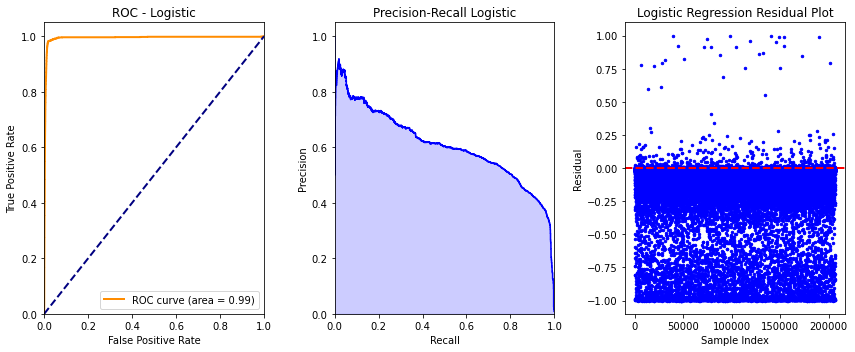

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# Plot ROC Curve on the left subplot

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
axs[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC - Logistic')
axs[0].legend(loc='lower right')

# Plot Precision-Recall Curve on the right subplot
precision, recall, _ = precision_recall_curve(y_test, y_prob)
axs[1].step(recall, precision, color='b', where='post')
axs[1].fill_between(recall, precision, alpha=0.2, color='b')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlim([0.0, 1.0])
axs[1].set_title('Precision-Recall Logistic')

# Residual Plot
residuals = y_test - y_prob
axs[2].scatter(range(len(residuals)), residuals, c='b', s=6)
axs[2].axhline(0, color='r', linestyle='--', linewidth=2)
axs[2].set_title('Logistic Regression Residual Plot')
axs[2].set_xlabel('Sample Index')
axs[2].set_ylabel('Residual')

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

Best Hyperparameters:
{
    'classifier__criterion': 'gini',
    'classifier__max_depth': 3,
    'classifier__max_features': 'auto',
    'classifier__min_samples_leaf': 15,
    'classifier__min_samples_split': 5,
}
Test F1 score : 0.4016326530612245
Test AUC score : 0.6461738618870291


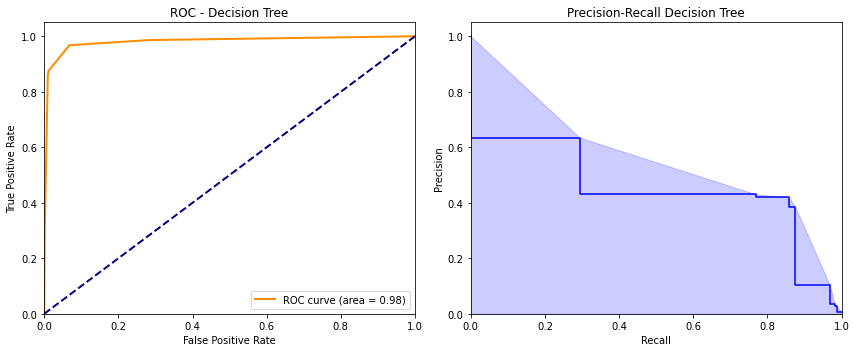

In [12]:

best_dt_estimator, preprocessor = getDecisionTreeResults(data_dictionary, model_cat_cols)

# Make predictions on the test set
y_pred = best_dt_estimator.predict(X_test)
# Compute the evaluation scores
auc_decisiontree = roc_auc_score(y_test, y_pred)
print(f"Test AUC score : {auc_decisiontree}")


fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Plot ROC Curve on the left subplot
y_prob = best_dt_estimator.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
axs[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC - Decision Tree')
axs[0].legend(loc='lower right')

# Plot Precision-Recall Curve on the right subplot
precision, recall, _ = precision_recall_curve(y_test, y_prob)
axs[1].step(recall, precision, color='b', where='post')
axs[1].fill_between(recall, precision, alpha=0.2, color='b')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlim([0.0, 1.0])
axs[1].set_title('Precision-Recall Decision Tree')

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

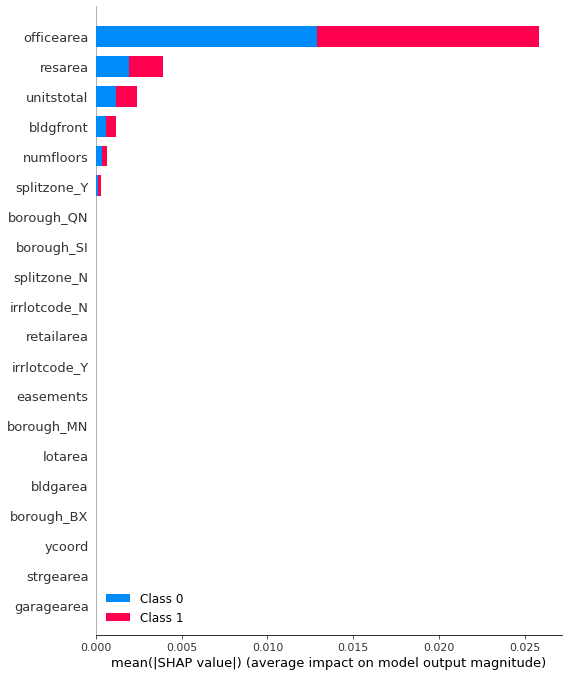

In [13]:
X_train_encoded = preprocessor.fit_transform(X_train)
feature_names = preprocessor.transformers_[0][1].get_feature_names(input_features=model_cat_cols).tolist() + numeric_cols
X_train_encoded = pd.DataFrame(X_train_encoded, columns = feature_names)

decision_tree_model = best_dt_estimator.named_steps['classifier']
# Initialize the SHAP explainer for the Decision Tree model
explainer = shap.Explainer(decision_tree_model, X_train_encoded)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train_encoded)

# Create a summary plot
shap.summary_plot(shap_values, X_train_encoded)


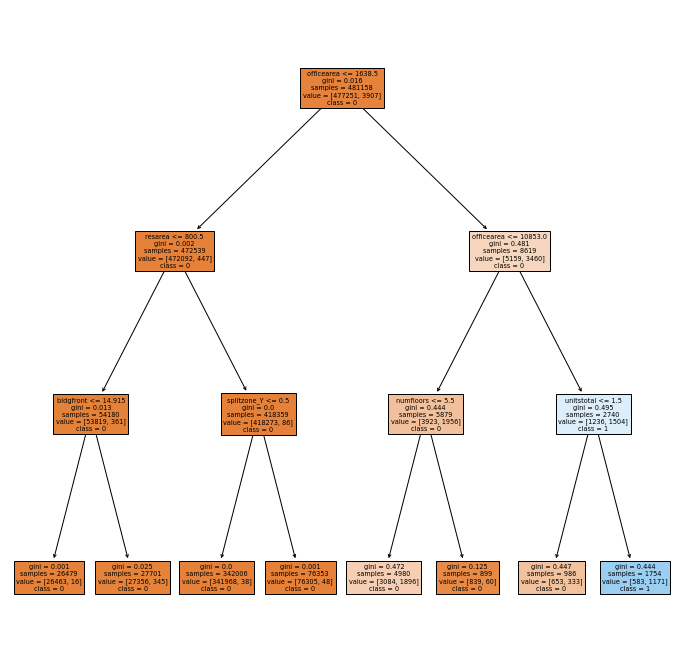

In [14]:
# Plot the Decision Tree
plt.figure(figsize=(12,12))
plot_tree(decision_tree_model, filled=True, feature_names=feature_names, class_names=['0', '1'])
plt.show()


Best Hyperparameters:
{
    'classifier__bootstrap': False,
    'classifier__criterion': 'entropy',
    'classifier__max_depth': 15,
    'classifier__max_features': 'log2',
    'classifier__min_samples_leaf': 1,
    'classifier__min_samples_split': 5,
    'classifier__n_estimators': 20,
}
Test F1 score : 0.7918876755070202
Test AUC score : 0.8781679406581128


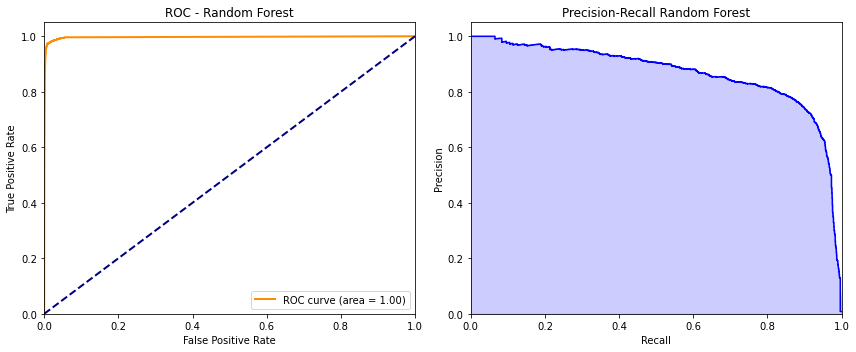

In [15]:
best_estimator, preprocessor = getRandomForestResults(data_dictionary, model_cat_cols)

# Make predictions on the test set
y_pred = best_estimator.predict(X_test)
# Compute the evaluation scores
auc_rf = roc_auc_score(y_test, y_pred)
print(f"Test AUC score : {auc_rf}")


fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Plot ROC Curve on the left subplot
y_prob = best_estimator.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
axs[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC - Random Forest')
axs[0].legend(loc='lower right')

# Plot Precision-Recall Curve on the right subplot
precision, recall, _ = precision_recall_curve(y_test, y_prob)
axs[1].step(recall, precision, color='b', where='post')
axs[1].fill_between(recall, precision, alpha=0.2, color='b')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlim([0.0, 1.0])
axs[1].set_title('Precision-Recall Random Forest')

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

100%|===================| 962004/962316 [16:24<00:00]        

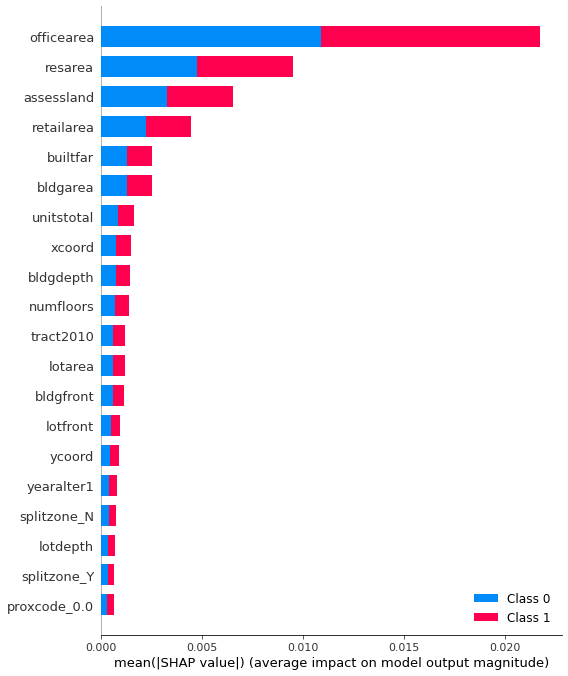

In [13]:
X_train_encoded = preprocessor.fit_transform(X_train)
feature_names = preprocessor.transformers_[0][1].get_feature_names(input_features=model_cat_cols).tolist() + numeric_cols
X_train_encoded = pd.DataFrame(X_train_encoded, columns = feature_names)

rf_model = best_estimator.named_steps['classifier']

# Initialize the SHAP explainer for the Decision Tree model
explainer = shap.Explainer(rf_model, X_train_encoded)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train_encoded, check_additivity=False)

# Create a summary plot
shap.summary_plot(shap_values, X_train_encoded)

Attributes with the most predictive power are 
- officearea
- resarea
- assessland
- retailarea

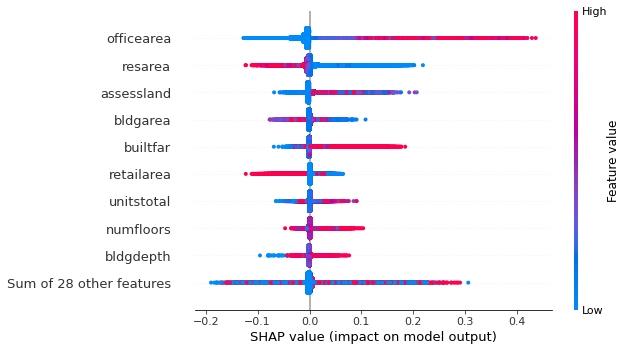

In [14]:
explainer = shap.Explainer(rf_model)
shap_values = explainer(X_train_encoded)
shap.plots.beeswarm(shap_values[:,:,1])


In [16]:
#predictions on the final test set. 
output_df['predictions'] = best_estimator.predict(test_imputed[X_test.columns])
output_df.to_csv('../Data/outputs/results.csv', index = False)

with open(os.path.join('../model_artifacts', 'model.pickle'), 'wb') as file:
    pickle.dump(best_estimator, file)